In [1]:
### from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [5]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_around_onset_combined_0.5sec_dhpc'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
#load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
#vhpc_animals = [ani for ani in animals if ani[0]!='d']
#expo_animals = 'c3m1', 'c3m2', 'c3f3', 'c10m6','c10m8'
#pre_animals  = 'c3m1', 'c3m2', 'c3f3', 'c10m6','c10m8'
#post_animals = 'c3m1', 'c3m2', 'c3f3', 'c10m6','c10m8'
#dhpc_animals = [ani for ani in animals if ani[0]=='d']
expo_animals  = 'dhpcg20',
pre_animals  = 'dhpcg20',
post_animals = 'dhpcg20',

In [9]:
sessions = 'expo', 'pre', 'post'

In [10]:
for sess in 'pre', 'post':

    exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset_0.5sec/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset_0.5sec/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [11]:
#have to extract 4_odor_expo varibles differently from that used above (because expo session folder begins with a numeral)
patterns_tb_expo = dict(zip(expo_animals,
                                [ut.load_variable('patterns_tb','../%s/4_odor_expo/notebooks/autorestore/decoding_around_onset_0.5sec'%ani)
                                                  for ani in expo_animals]))

labels_expo = dict(zip(expo_animals,
                                [ut.load_variable('labels','../%s/4_odor_expo/notebooks/autorestore/decoding_around_onset_0.5sec'%ani)
                                                  for ani in expo_animals]))

In [12]:
#from referenced notebook, 26 time bins total beginning at -4s prior to odor onset and running through 9s post onset

#t_start0 = -4  # sec
#t_stop0 = 9  # sec

In [13]:
#create dict (w/ animals as keys) for each timebin/session combination
for sess in sessions:
    for t in range(0,26):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 expo dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 pre dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20 post dhpcg20


In [14]:
import h5py

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):
#     which_train = range(90)
#     which_test = range(90)

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
        

def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict


In [15]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_beta(patterns_train,patterns_test, labels_train, labels_test, relabel=None, n_cells=None):
    
    if relabel is not None:
        labels_train = np.r_[[relabel[l] for l in labels_train]]
        labels_test = np.r_[[relabel[l] for l in labels_test]]
    else:
        labels_train = labels_train
        labels_test = labels_test
    
    if n_cells is None:
        cells = list(range(patterns_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_train[:, cells], labels_train)
    scores = decoder.score(patterns_test[:, cells], labels_test)
    decoder.fit(patterns_test[:, cells], labels_test)
    return np.append(scores, decoder.score(patterns_train[:, cells], labels_train))

In [16]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [17]:
%%time
#get train and test subsamples for each timebin, for each session
for t in range(0,26):
    for sess in sessions:
        exec("x_%s_%s,y_%s_%s, xT_%s_%s, yT_%s_%s = combine_train_test_patterns(patterns_tb_%s_%s, labels_%s,\
        train_test_split=0.5, classes=range(1,5), n_cells=None, relabel=None, relabel_test=None)"%(t,sess,t,sess,t,sess,t,sess,
        t,sess,sess))
        
for t in range(26): # number of time bins
    exec('scores_tb_%s_all = {}'%t)
    n_loops = 100
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_all"%t)[sess] = np.r_[[do_test_within_beta(eval('x_%s_%s'%(t,sess)), eval('xT_%s_%s'%(t,sess)), 
                            eval('y_%s_%s'%(t,sess)), eval('yT_%s_%s'%(t,sess)) ,relabel=None) for i in range(n_loops)]]
        #exec("scores_tb_%s['%s'] = np.r_[[do_test_within_beta(x_%s_%s,xT_%s_%s, y_%s_%s, yT_%s_%s, relabel=relabel)]]"%(t,sess,t,sess,t,sess,t,sess,t,sess))

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13 expo 14 pre 14 post 14 expo 15 pre 15 post 15 expo 16 pre 16 post 16 expo 17 pre 17 post 17 expo 18 pre 18 post 18 expo 19 pre 19 post 19 expo 20 pre 20 post 20 expo 21 pre 21 post 21 expo 22 pre 22 post 22 expo 23 pre 23 post 23 expo 24 pre 24 post 24 expo 25 pre 25 post 25CPU times: user 3min 7s, sys: 128 ms, total: 3min 7s
Wall time: 3min 7s



In [18]:
%%time
#now recode labels to comapre specific trials. This is combining both CS+ odors vs both CS- odors
relabel = {1:0,2:0,3:1,4:1}
for t in range(0,26):
    for sess in sessions:
        exec("x_%s_%s,y_%s_%s, xT_%s_%s, yT_%s_%s = combine_train_test_patterns(patterns_tb_%s_%s, labels_%s,\
        train_test_split=0.5, classes=range(1,5), n_cells=None, relabel=relabel, relabel_test=None)"%(t,sess,t,sess,t,sess,t,sess,
        t,sess,sess))
        
for t in range(26): # number of time bins
    exec('scores_tb_%s_CSPvsCSM = {}'%t)
    n_loops = 100
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CSPvsCSM"%t)[sess] = np.r_[[do_test_within_beta(eval('x_%s_%s'%(t,sess)), eval('xT_%s_%s'%(t,sess)), 
                            eval('y_%s_%s'%(t,sess)), eval('yT_%s_%s'%(t,sess)) ,relabel=None) for i in range(n_loops)]]
        #exec("scores_tb_%s['%s'] = np.r_[[do_test_within_beta(x_%s_%s,xT_%s_%s, y_%s_%s, yT_%s_%s, relabel=relabel)]]"%(t,sess,t,sess,t,sess,t,sess,t,sess))

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13 expo 14 pre 14 post 14 expo 15 pre 15 post 15 expo 16 pre 16 post 16 expo 17 pre 17 post 17 expo 18 pre 18 post 18 expo 19 pre 19 post 19 expo 20 pre 20 post 20 expo 21 pre 21 post 21 expo 22 pre 22 post 22 expo 23 pre 23 post 23 expo 24 pre 24 post 24 expo 25 pre 25 post 25CPU times: user 2min 11s, sys: 68 ms, total: 2min 11s
Wall time: 2min 10s



In [19]:
%%time
relabel = {1:0,2:1,3:-1,4:-1}
for t in range(0,26):
    for sess in sessions:
        exec("x_%s_%s,y_%s_%s, xT_%s_%s, yT_%s_%s = combine_train_test_patterns(patterns_tb_%s_%s, labels_%s,\
        train_test_split=0.5, classes=range(1,5), n_cells=None, relabel=relabel, relabel_test=None)"%(t,sess,t,sess,t,sess,t,sess,
        t,sess,sess))
        
for t in range(26): # number of time bins
    exec('scores_tb_%s_CS1vsCS2 = {}'%t)
    n_loops = 100
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS1vsCS2"%t)[sess] = np.r_[[do_test_within_beta(eval('x_%s_%s'%(t,sess)), eval('xT_%s_%s'%(t,sess)), 
                            eval('y_%s_%s'%(t,sess)), eval('yT_%s_%s'%(t,sess)) ,relabel=None) for i in range(n_loops)]]
        #exec("scores_tb_%s['%s'] = np.r_[[do_test_within_beta(x_%s_%s,xT_%s_%s, y_%s_%s, yT_%s_%s,\
        #relabel=relabel)]]"%(t,sess,t,sess,t,sess,t,sess,t,sess))

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13 expo 14 pre 14 post 14 expo 15 pre 15 post 15 expo 16 pre 16 post 16 expo 17 pre 17 post 17 expo 18 pre 18 post 18 expo 19 pre 19 post 19 expo 20 pre 20 post 20 expo 21 pre 21 post 21 expo 22 pre 22 post 22 expo 23 pre 23 post 23 expo 24 pre 24 post 24 expo 25 pre 25 post 25CPU times: user 45.4 s, sys: 68 ms, total: 45.5 s
Wall time: 45.3 s



In [20]:
%%time
relabel = {1:0,2:-1,3:1,4:-1}
for t in range(0,26):
    for sess in sessions:
        exec("x_%s_%s,y_%s_%s, xT_%s_%s, yT_%s_%s = combine_train_test_patterns(patterns_tb_%s_%s, labels_%s,\
        train_test_split=0.5, classes=range(1,5), n_cells=None, relabel=relabel, relabel_test=None)"%(t,sess,t,sess,t,sess,t,sess,
        t,sess,sess))
        
for t in range(26): # number of time bins
    exec('scores_tb_%s_CS1vsCS3 = {}'%t)
    n_loops = 100
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS1vsCS3"%t)[sess] = np.r_[[do_test_within_beta(eval('x_%s_%s'%(t,sess)), eval('xT_%s_%s'%(t,sess)), 
                            eval('y_%s_%s'%(t,sess)), eval('yT_%s_%s'%(t,sess)) ,relabel=None) for i in range(n_loops)]]
        #exec("scores_tb_%s['%s'] = np.r_[[do_test_within_beta(x_%s_%s,xT_%s_%s, y_%s_%s, yT_%s_%s, relabel=relabel)]]"%(t,sess,t,sess,t,sess,t,sess,t,sess))

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13 expo 14 pre 14 post 14 expo 15 pre 15 post 15 expo 16 pre 16 post 16 expo 17 pre 17 post 17 expo 18 pre 18 post 18 expo 19 pre 19 post 19 expo 20 pre 20 post 20 expo 21 pre 21 post 21 expo 22 pre 22 post 22 expo 23 pre 23 post 23 expo 24 pre 24 post 24 expo 25 pre 25 post 25CPU times: user 42.4 s, sys: 64 ms, total: 42.4 s
Wall time: 42.3 s



In [21]:
%%time
relabel = {1:0,2:-1,3:-1,4:1}
for t in range(0,26):
    for sess in sessions:
        exec("x_%s_%s,y_%s_%s, xT_%s_%s, yT_%s_%s = combine_train_test_patterns(patterns_tb_%s_%s, labels_%s,\
        train_test_split=0.5, classes=range(1,5), n_cells=None, relabel=relabel, relabel_test=None)"%(t,sess,t,sess,t,sess,t,sess,
        t,sess,sess))
        
for t in range(26): # number of time bins
    exec('scores_tb_%s_CS1vsCS4 = {}'%t)
    n_loops = 100
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS1vsCS4"%t)[sess] = np.r_[[do_test_within_beta(eval('x_%s_%s'%(t,sess)), eval('xT_%s_%s'%(t,sess)), 
                            eval('y_%s_%s'%(t,sess)), eval('yT_%s_%s'%(t,sess)) ,relabel=None) for i in range(n_loops)]]
        #exec("scores_tb_%s['%s'] = np.r_[[do_test_within_beta(x_%s_%s,xT_%s_%s, y_%s_%s, yT_%s_%s, relabel=relabel)]]"%(t,sess,t,sess,t,sess,t,sess,t,sess))

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13 expo 14 pre 14 post 14 expo 15 pre 15 post 15 expo 16 pre 16 post 16 expo 17 pre 17 post 17 expo 18 pre 18 post 18 expo 19 pre 19 post 19 expo 20 pre 20 post 20 expo 21 pre 21 post 21 expo 22 pre 22 post 22 expo 23 pre 23 post 23 expo 24 pre 24 post 24 expo 25 pre 25 post 25CPU times: user 43.9 s, sys: 68 ms, total: 44 s
Wall time: 43.8 s



In [22]:
%%time
relabel = {1:-1,2:0,3:1,4:-1}
for t in range(0,26):
    for sess in sessions:
        exec("x_%s_%s,y_%s_%s, xT_%s_%s, yT_%s_%s = combine_train_test_patterns(patterns_tb_%s_%s, labels_%s,\
        train_test_split=0.5, classes=range(1,5), n_cells=None, relabel=relabel, relabel_test=None)"%(t,sess,t,sess,t,sess,t,sess,
        t,sess,sess))
        
for t in range(26): # number of time bins
    exec('scores_tb_%s_CS2vsCS3 = {}'%t)
    n_loops = 100
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS2vsCS3"%t)[sess] = np.r_[[do_test_within_beta(eval('x_%s_%s'%(t,sess)), eval('xT_%s_%s'%(t,sess)), 
                            eval('y_%s_%s'%(t,sess)), eval('yT_%s_%s'%(t,sess)) ,relabel=None) for i in range(n_loops)]]
        #exec("scores_tb_%s['%s'] = np.r_[[do_test_within_beta(x_%s_%s,xT_%s_%s, y_%s_%s, yT_%s_%s, relabel=relabel)]]"%(t,sess,t,sess,t,sess,t,sess,t,sess))

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13 expo 14 pre 14 post 14 expo 15 pre 15 post 15 expo 16 pre 16 post 16 expo 17 pre 17 post 17 expo 18 pre 18 post 18 expo 19 pre 19 post 19 expo 20 pre 20 post 20 expo 21 pre 21 post 21 expo 22 pre 22 post 22 expo 23 pre 23 post 23 expo 24 pre 24 post 24 expo 25 pre 25 post 25CPU times: user 42.9 s, sys: 64 ms, total: 43 s
Wall time: 42.8 s



In [23]:
%%time
relabel = {1:-1,2:0,3:-1,4:1}
for t in range(0,26):
    for sess in sessions:
        exec("x_%s_%s,y_%s_%s, xT_%s_%s, yT_%s_%s = combine_train_test_patterns(patterns_tb_%s_%s, labels_%s,\
        train_test_split=0.5, classes=range(1,5), n_cells=None, relabel=relabel, relabel_test=None)"%(t,sess,t,sess,t,sess,t,sess,
        t,sess,sess))
        
for t in range(26): # number of time bins
    exec('scores_tb_%s_CS2vsCS4 = {}'%t)
    n_loops = 100
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS2vsCS4"%t)[sess] = np.r_[[do_test_within_beta(eval('x_%s_%s'%(t,sess)), eval('xT_%s_%s'%(t,sess)), 
                            eval('y_%s_%s'%(t,sess)), eval('yT_%s_%s'%(t,sess)) ,relabel=None) for i in range(n_loops)]]
        #exec("scores_tb_%s['%s'] = np.r_[[do_test_within_beta(x_%s_%s,xT_%s_%s, y_%s_%s, yT_%s_%s, relabel=relabel)]]"%(t,sess,t,sess,t,sess,t,sess,t,sess))

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13 expo 14 pre 14 post 14 expo 15 pre 15 post 15 expo 16 pre 16 post 16 expo 17 pre 17 post 17 expo 18 pre 18 post 18 expo 19 pre 19 post 19 expo 20 pre 20 post 20 expo 21 pre 21 post 21 expo 22 pre 22 post 22 expo 23 pre 23 post 23 expo 24 pre 24 post 24 expo 25 pre 25 post 25CPU times: user 44 s, sys: 104 ms, total: 44.1 s
Wall time: 43.9 s



In [24]:
%%time
relabel = {1:-1,2:-1,3:0,4:1}
for t in range(0,26):
    for sess in sessions:
        exec("x_%s_%s,y_%s_%s, xT_%s_%s, yT_%s_%s = combine_train_test_patterns(patterns_tb_%s_%s, labels_%s,\
        train_test_split=0.5, classes=range(1,5), n_cells=None, relabel=relabel, relabel_test=None)"%(t,sess,t,sess,t,sess,t,sess,
        t,sess,sess))
        
for t in range(26): # number of time bins
    exec('scores_tb_%s_CS3vsCS4 = {}'%t)
    n_loops = 100
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_CS3vsCS4"%t)[sess] = np.r_[[do_test_within_beta(eval('x_%s_%s'%(t,sess)), eval('xT_%s_%s'%(t,sess)), 
                            eval('y_%s_%s'%(t,sess)), eval('yT_%s_%s'%(t,sess)) ,relabel=None) for i in range(n_loops)]]
        #exec("scores_tb_%s['%s'] = np.r_[[do_test_within_beta(x_%s_%s,xT_%s_%s, y_%s_%s, yT_%s_%s, relabel=relabel)]]"%(t,sess,t,sess,t,sess,t,sess,t,sess))

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13 expo 14 pre 14 post 14 expo 15 pre 15 post 15 expo 16 pre 16 post 16 expo 17 pre 17 post 17 expo 18 pre 18 post 18 expo 19 pre 19 post 19 expo 20 pre 20 post 20 expo 21 pre 21 post 21 expo 22 pre 22 post 22 expo 23 pre 23 post 23 expo 24 pre 24 post 24 expo 25 pre 25 post 25CPU times: user 47.5 s, sys: 104 ms, total: 47.6 s
Wall time: 47.5 s



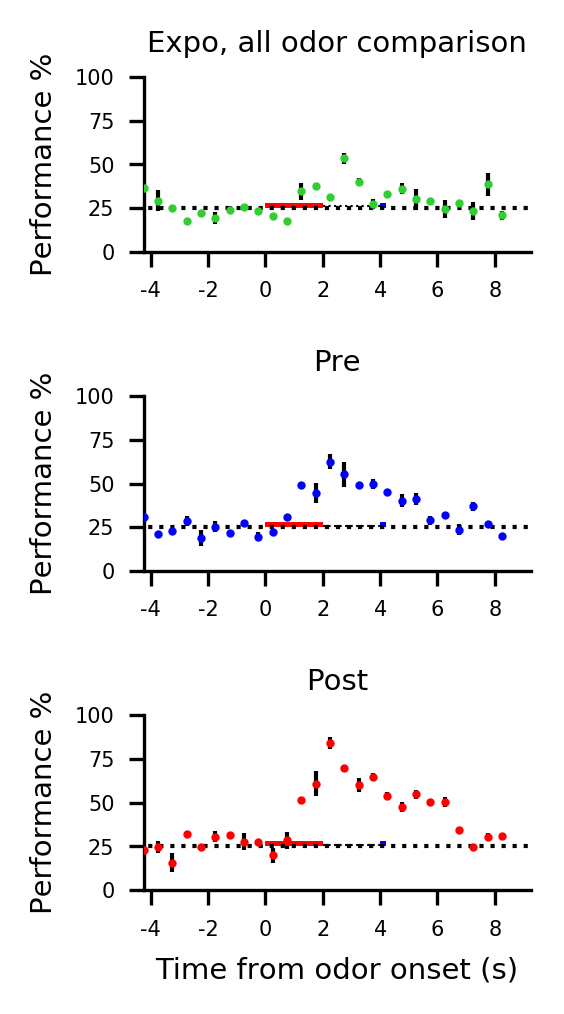

In [25]:
fig, ax = pl.subplots(3,1, figsize=(2, 3.5))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(26):
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_all['expo']"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_all['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_all['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_all['expo']"%t).shape[-1])
    ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_all['pre']"%t))*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_all['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_all['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_all['pre']"%t).shape[-1])
    ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_all['post']"%t))*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_all['post']"%t))*100
    s = np.std(eval("scores_tb_%s_all['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_all['post']"%t).shape[-1])
    ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
for x in range (0,3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-4.25, 9.25)
    ax[x].set_xticks(np.arange(-4,9, 2))
    ax[x].set_xticklabels(np.arange(-4,9, 2))
    ax[x].hlines(25, -6,11, color='k', lw=1, linestyles='dotted')
    ax[2].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo, all odor comparison')
ax[1].set_title('Pre')
ax[2].set_title('Post')
fig.tight_layout(pad=2.3)


fig.savefig('../img/%s_all_odors.jpg'%NOTEBOOK_NAME)

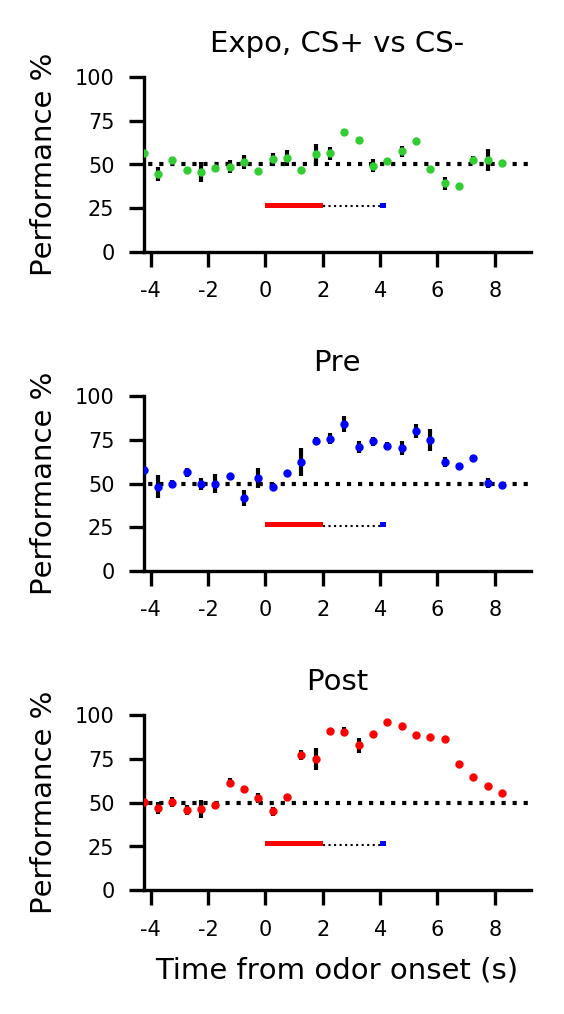

In [26]:
fig, ax = pl.subplots(3,1, figsize=(2, 3.5))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(26):
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CSPvsCSM['expo']"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CSPvsCSM['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CSPvsCSM['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CSPvsCSM['expo']"%t).shape[-1])
    ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CSPvsCSM['pre']"%t))*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CSPvsCSM['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CSPvsCSM['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CSPvsCSM['pre']"%t).shape[-1])
    ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CSPvsCSM['post']"%t))*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CSPvsCSM['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CSPvsCSM['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CSPvsCSM['post']"%t).shape[-1])
    ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
for x in range (0,3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-4.25, 9.25)
    ax[x].set_xticks(np.arange(-4,9, 2))
    ax[x].set_xticklabels(np.arange(-4,9, 2))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[2].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo, CS+ vs CS-')
ax[1].set_title('Pre')
ax[2].set_title('Post')
fig.tight_layout(pad=2.3)


fig.savefig('../img/%s_CSPvsCSM.jpg'%NOTEBOOK_NAME)

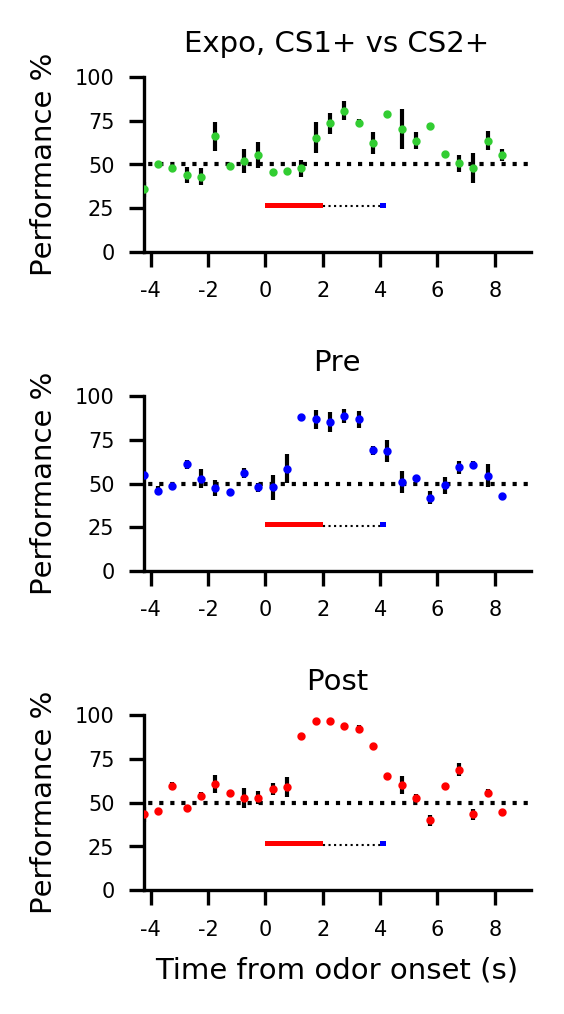

In [27]:
fig, ax = pl.subplots(3,1, figsize=(2, 3.5))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(26):
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS2['expo']"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS2['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS2['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS2['expo']"%t).shape[-1])
    ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS2['pre']"%t))*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS2['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS2['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS2['pre']"%t).shape[-1])
    ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS2['post']"%t))*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS2['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS2['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS2['post']"%t).shape[-1])
    ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
for x in range (0,3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-4.25, 9.25)
    ax[x].set_xticks(np.arange(-4,9, 2))
    ax[x].set_xticklabels(np.arange(-4,9, 2))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[2].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo, CS1+ vs CS2+')
ax[1].set_title('Pre')
ax[2].set_title('Post')
fig.tight_layout(pad=2.3)


fig.savefig('../img/%s_CS1vsCS2.jpg'%NOTEBOOK_NAME)

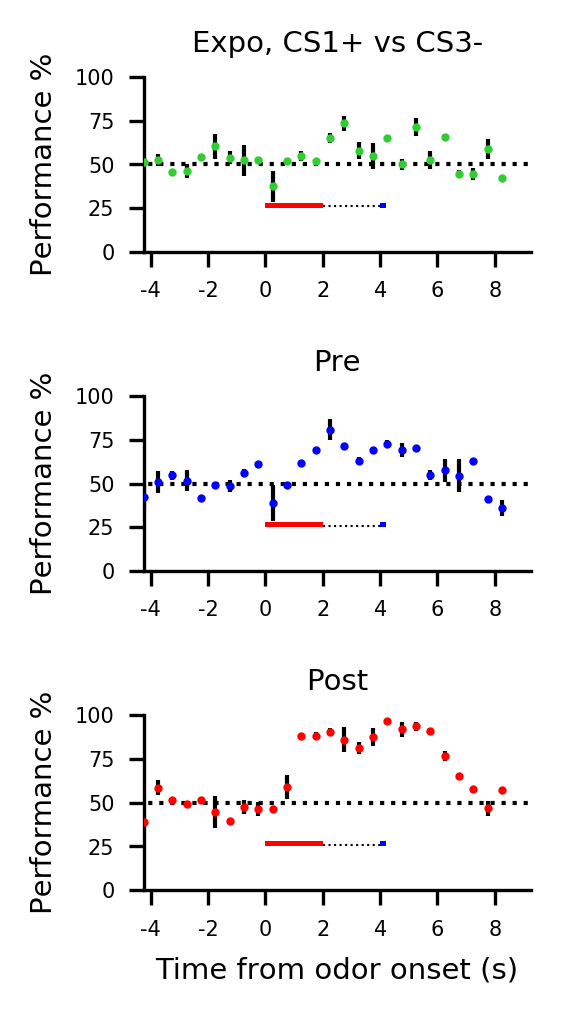

In [28]:
fig, ax = pl.subplots(3,1, figsize=(2, 3.5))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(26):
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS3['expo']"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS3['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS3['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS3['expo']"%t).shape[-1])
    ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS3['pre']"%t))*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS3['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS3['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS3['pre']"%t).shape[-1])
    ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS3['post']"%t))*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS3['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS3['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS3['post']"%t).shape[-1])
    ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
for x in range (0,3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-4.25, 9.25)
    ax[x].set_xticks(np.arange(-4,9, 2))
    ax[x].set_xticklabels(np.arange(-4,9, 2))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[2].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo, CS1+ vs CS3-')
ax[1].set_title('Pre')
ax[2].set_title('Post')
fig.tight_layout(pad=2.3)


fig.savefig('../img/%s_CS1vsCS3.jpg'%NOTEBOOK_NAME)

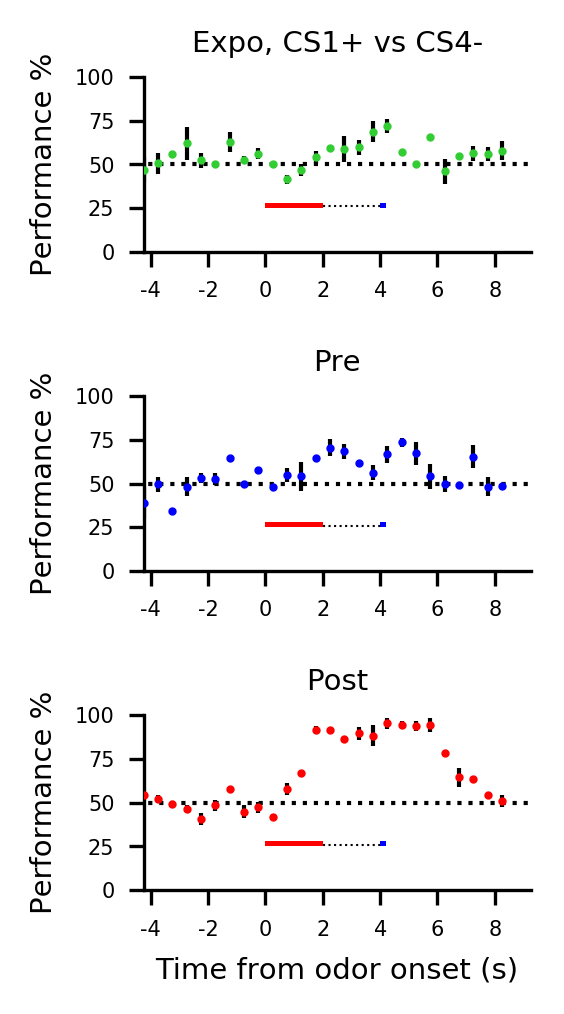

In [29]:
fig, ax = pl.subplots(3,1, figsize=(2, 3.5))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(26):
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS4['expo']"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS4['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS4['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS4['expo']"%t).shape[-1])
    ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS4['pre']"%t))*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS4['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS4['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS4['pre']"%t).shape[-1])
    ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS4['post']"%t))*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS4['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS4['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS4['post']"%t).shape[-1])
    ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
for x in range (0,3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-4.25, 9.25)
    ax[x].set_xticks(np.arange(-4,9, 2))
    ax[x].set_xticklabels(np.arange(-4,9, 2))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[2].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo, CS1+ vs CS4-')
ax[1].set_title('Pre')
ax[2].set_title('Post')
fig.tight_layout(pad=2.3)


fig.savefig('../img/%s_CS1vsCS4.jpg'%NOTEBOOK_NAME)

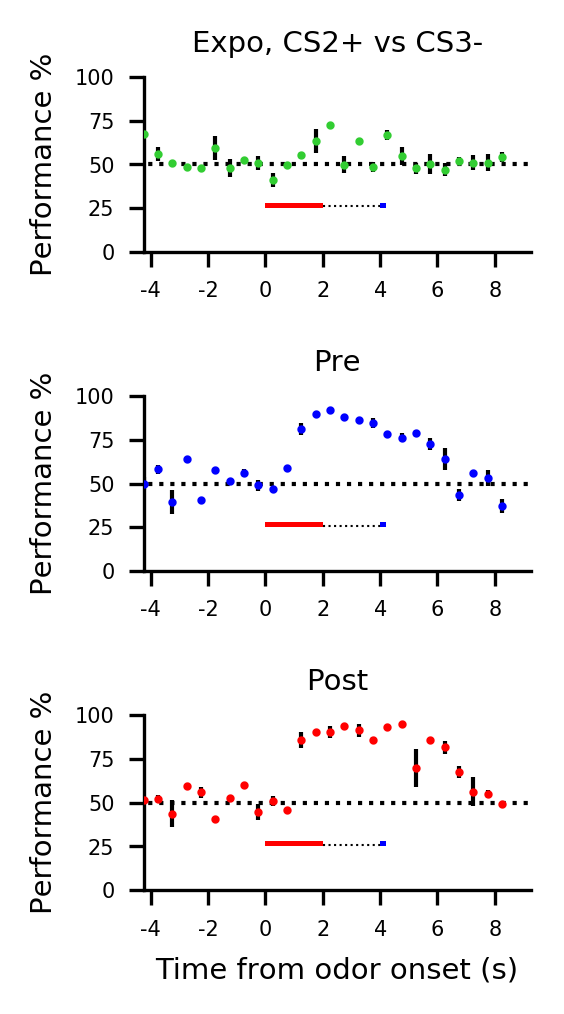

In [30]:
fig, ax = pl.subplots(3,1, figsize=(2, 3.5))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(26):
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS3['expo']"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS2vsCS3['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS2vsCS3['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS2vsCS3['expo']"%t).shape[-1])
    ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS3['pre']"%t))*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS2vsCS3['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS2vsCS3['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS2vsCS3['pre']"%t).shape[-1])
    ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS3['post']"%t))*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS2vsCS3['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS2vsCS3['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS2vsCS3['post']"%t).shape[-1])
    ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
for x in range (0,3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-4.25, 9.25)
    ax[x].set_xticks(np.arange(-4,9, 2))
    ax[x].set_xticklabels(np.arange(-4,9, 2))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[2].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo, CS2+ vs CS3-')
ax[1].set_title('Pre')
ax[2].set_title('Post')
fig.tight_layout(pad=2.3)


fig.savefig('../img/%s_CS2vsCS3.jpg'%NOTEBOOK_NAME)

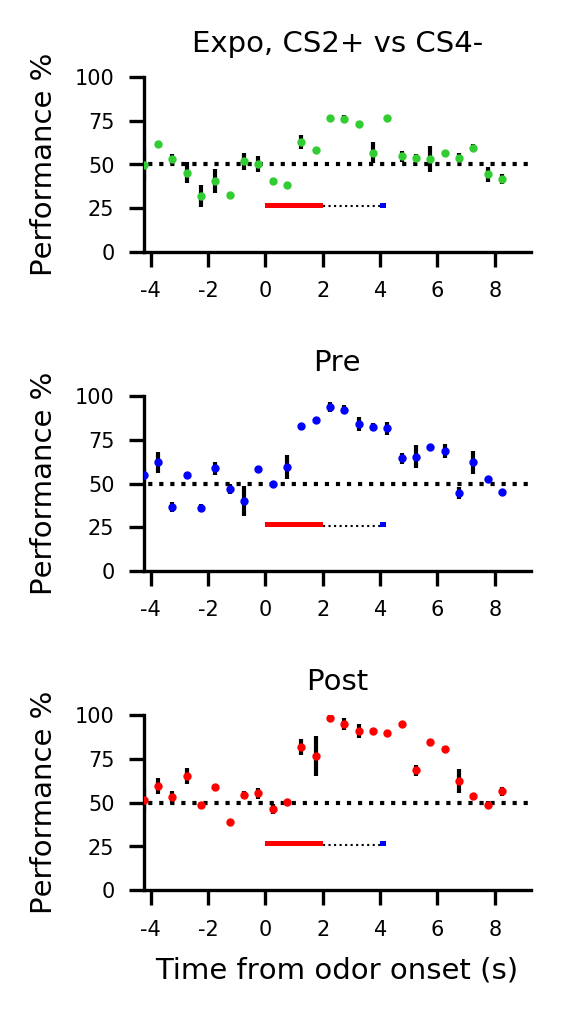

In [31]:
fig, ax = pl.subplots(3,1, figsize=(2, 3.5))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(26):
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS4['expo']"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS2vsCS4['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS2vsCS4['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS2vsCS4['expo']"%t).shape[-1])
    ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS4['pre']"%t))*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS2vsCS4['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS2vsCS4['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS2vsCS4['pre']"%t).shape[-1])
    ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS4['post']"%t))*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS2vsCS4['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS2vsCS4['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS2vsCS4['post']"%t).shape[-1])
    ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
for x in range (0,3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-4.25, 9.25)
    ax[x].set_xticks(np.arange(-4,9, 2))
    ax[x].set_xticklabels(np.arange(-4,9, 2))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[2].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo, CS2+ vs CS4-')
ax[1].set_title('Pre')
ax[2].set_title('Post')
fig.tight_layout(pad=2.3)


fig.savefig('../img/%s_CS2vsCS4.jpg'%NOTEBOOK_NAME)

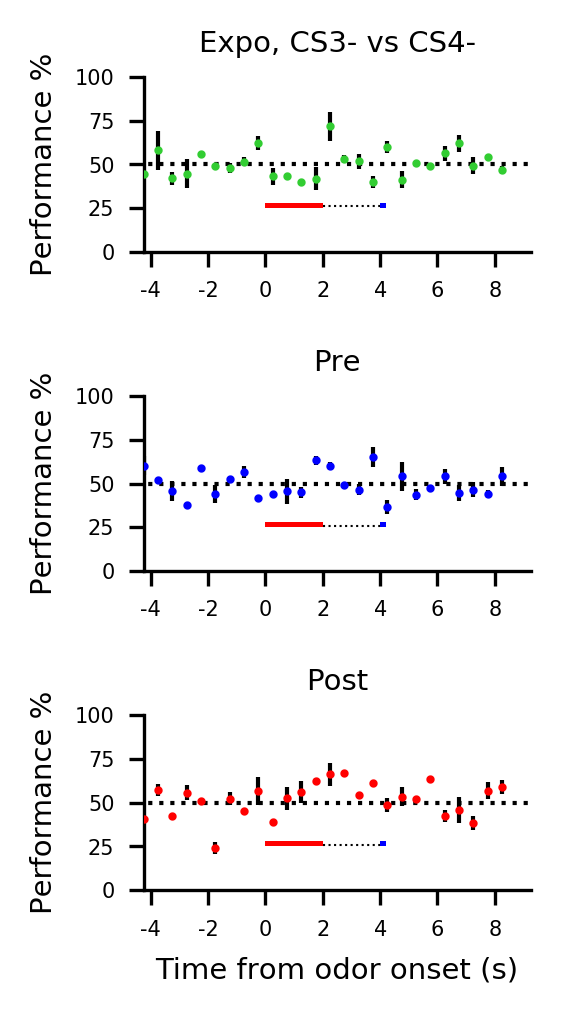

In [32]:
fig, ax = pl.subplots(3,1, figsize=(2, 3.5))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(26):
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS3vsCS4['expo']"%t))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS3vsCS4['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS3vsCS4['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS3vsCS4['expo']"%t).shape[-1])
    ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS3vsCS4['pre']"%t))*100, 'o', color='blue', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS3vsCS4['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS3vsCS4['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS3vsCS4['pre']"%t).shape[-1])
    ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS3vsCS4['post']"%t))*100, 'o', color='red', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS3vsCS4['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS3vsCS4['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS3vsCS4['post']"%t).shape[-1])
    ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
for x in range (0,3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-4.25, 9.25)
    ax[x].set_xticks(np.arange(-4,9, 2))
    ax[x].set_xticklabels(np.arange(-4,9, 2))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[2].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Expo, CS3- vs CS4-')
ax[1].set_title('Pre')
ax[2].set_title('Post')
fig.tight_layout(pad=2.3)


fig.savefig('../img/%s_CS3vsCS4.jpg'%NOTEBOOK_NAME)

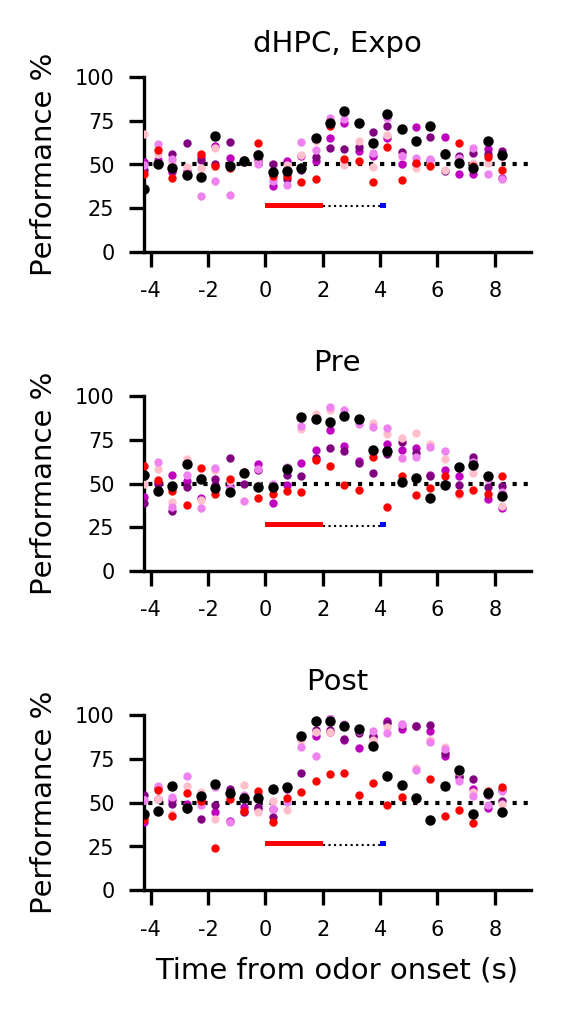

In [35]:
fig, ax = pl.subplots(3,1, figsize=(2, 3.5))

#t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
for t in range(26):
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS3['expo']"%t))*100, 'o', color='m', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS3['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS3['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS3['expo']"%t).shape[-1])
    #ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS4['expo']"%t))*100, 'o', color='purple', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS4['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS4['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS4['expo']"%t).shape[-1])
    #ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS3['expo']"%t))*100, 'o', color='pink', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS3['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS3['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS3['expo']"%t).shape[-1])
    #ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS4['expo']"%t))*100, 'o', color='violet', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS4['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS4['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS4['expo']"%t).shape[-1])
    #ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS3vsCS4['expo']"%t))*100, 'o', color='r', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS3vsCS4['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS3vsCS4['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS3vsCS4['expo']"%t).shape[-1])
    #ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[0].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS2['expo']"%t))*100, 'o', color='k', ls='-',lw=.5, zorder=19 ,ms=1,
              markersize=1.5)
    m = np.mean(eval("scores_tb_%s_CS1vsCS2['expo']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS2['expo']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS2['expo']"%t).shape[-1])
    #ax[0].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    
   
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS3['pre']"%t))*100, 'o', color='m', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS3['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS3['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS3['pre']"%t).shape[-1])
    #ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS4['pre']"%t))*100, 'o', color='purple', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS4['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS4['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS4['pre']"%t).shape[-1])
    #ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS3['pre']"%t))*100, 'o', color='pink', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS3['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS3['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS3['pre']"%t).shape[-1])
    #ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS4['pre']"%t))*100, 'o', color='violet', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS4['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS4['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS4['pre']"%t).shape[-1])
    #ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS3vsCS4['pre']"%t))*100, 'o', color='r', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS3vsCS4['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS3vsCS4['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS3vsCS4['pre']"%t).shape[-1])
    #ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[1].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS2['pre']"%t))*100, 'o', color='k', ls='-',lw=.5, zorder=19 ,ms=1,
              markersize=1.5)
    m = np.mean(eval("scores_tb_%s_CS1vsCS2['pre']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS2['pre']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS2['pre']"%t).shape[-1])
    #ax[1].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS3['post']"%t))*100, 'o', color='m', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS3['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS3['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS3['post']"%t).shape[-1])
    #ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS4['post']"%t))*100, 'o', color='purple', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS4['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS4['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS4['post']"%t).shape[-1])
    #ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS3['post']"%t))*100, 'o', color='pink', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS3['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS3['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS3['post']"%t).shape[-1])
    #ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS2vsCS4['post']"%t))*100, 'o', color='violet', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS1vsCS4['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS4['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS4['post']"%t).shape[-1])
    #ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS3vsCS4['post']"%t))*100, 'o', color='r', ls='-',lw=.5, zorder=19 ,ms=1)
    m = np.mean(eval("scores_tb_%s_CS3vsCS4['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS3vsCS4['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS3vsCS4['post']"%t).shape[-1])
    #ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    ax[2].plot((t/2.0)-4.25, np.mean(eval("scores_tb_%s_CS1vsCS2['post']"%t))*100, 'o', color='k', ls='-',lw=.5, zorder=19 ,ms=1,
              markersize=1.5)
    m = np.mean(eval("scores_tb_%s_CS1vsCS2['post']"%t))*100
    s = np.std(eval("scores_tb_%s_CS1vsCS2['post']"%t))*100 / np.sqrt(eval("scores_tb_%s_CS1vsCS2['post']"%t).shape[-1])
    #ax[2].errorbar((t/2.0)-4.25, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    
for x in range (0,3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-4.25, 9.25)
    ax[x].set_xticks(np.arange(-4,9, 2))
    ax[x].set_xticklabels(np.arange(-4,9, 2))
    ax[x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
    ax[2].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('dHPC, Expo')
ax[1].set_title('Pre')
ax[2].set_title('Post')
#leg = '1v3','1v4','2v3','2v4','3v4','1v2'
#ax[0].legend(leg, loc='best')
fig.tight_layout(pad=2.3)


fig.savefig('../img/%s_all_combo.jpg'%NOTEBOOK_NAME)

# Only got this far. Have not touched the below

# Now for equalizing cell #s across all sess by using global min

# And now for decoding across time bins!

In [33]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'np'. Skipping...
